In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import imageio
import pickle
from tqdm import tqdm_notebook as tqdm

In [4]:
def depth_two_uint8_to_float(top_bits, bottom_bits):
    """ Converts a RGB-coded depth into float valued depth. """
    depth_map = (top_bits * 2**8 + bottom_bits).astype('float32')
    depth_map /= float(2**16 - 1)
    depth_map *= 5.0
    return depth_map

In [5]:
train_path = "/home/claus/data/RHD_published_v2/training"
mask_path = os.path.join(train_path, "mask")
color_path = os.path.join(train_path, "color")
depth_path = os.path.join(train_path, "depth")
annotations_path = os.path.join(train_path, "anno_training.pickle")

In [6]:
image_index = [40926, 15017, 25901]

In [7]:
with open(annotations_path, 'rb') as f:
    annotations = pickle.load(f)

In [8]:
def get_bbox(start, end, index, return_coords):
    visible_mask = annotations[index]['uv_vis'][start:end,2] != 0
    xs = annotations[index]['uv_vis'][start:end,0][visible_mask]
    ys = annotations[index]['uv_vis'][start:end,1][visible_mask]
    if(len(xs) > 0 and len(ys) > 0):
        min_x = np.min(xs)
        max_x = np.max(xs)
        min_y = np.min(ys)
        max_y = np.max(ys)

        width = max_x - min_x
        height = max_y - min_y

        if return_coords:
            return int(min_x), int(min_y), int(max_x), int(max_y)
        else:
            return (min_x, min_y), width, height
    else:
        return None

In [9]:
def get_bbox_left(index, return_coords=False):
    return get_bbox(0, 21, index, return_coords=return_coords)

def get_bbox_right(index, return_coords=False):
    return get_bbox(21, 42, index, return_coords=return_coords)

In [10]:
masks = []
colors = []
depths = []

for f in os.listdir(mask_path):
    for i in image_index:
        if f.split('.')[0] == str(i):
            im = cv2.imread(os.path.join(mask_path, f))
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            masks.append(im)

for f in os.listdir(color_path):
    for i in image_index:
        if f.split('.')[0] == str(i):
            im = cv2.imread(os.path.join(color_path, f))
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            colors.append(im)

for f in os.listdir(depth_path):
    for i in image_index:
        if f.split('.')[0] == str(i):
            im = cv2.imread(os.path.join(depth_path, f))
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = depth_two_uint8_to_float(im[:, :, 0], im[:, :, 1])
            depths.append(im)

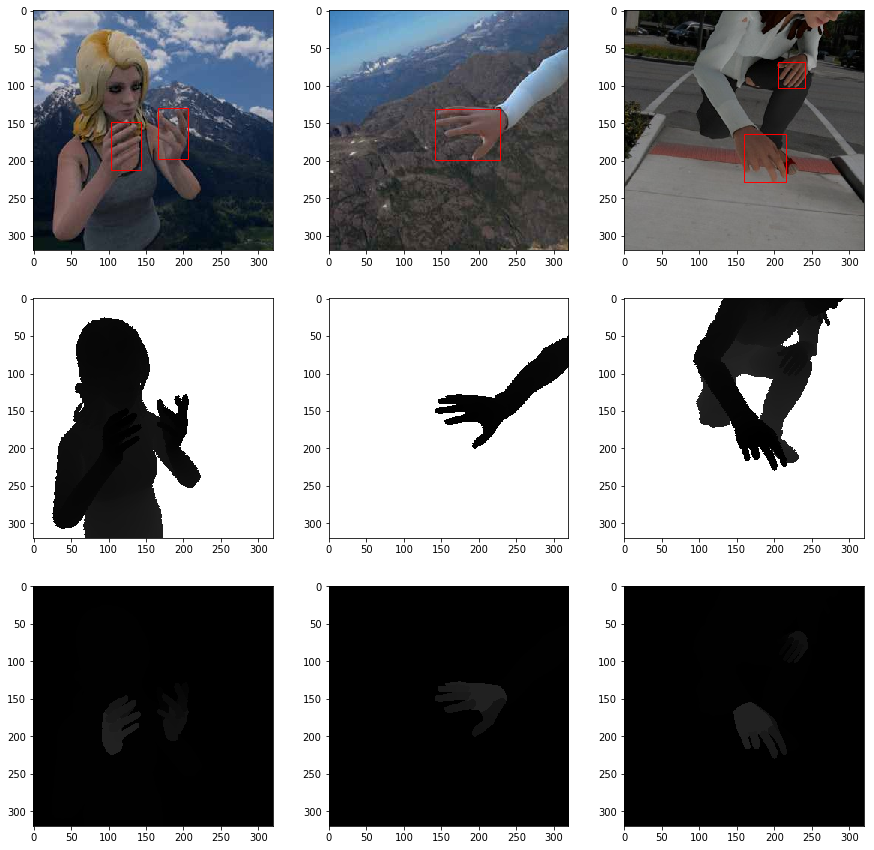

In [11]:
num_plots = 3 * len(image_index)
f, subs = plt.subplots(len(image_index), 3, figsize=(15, 15))

for i, c in enumerate(colors):
    index = image_index[i]
    bbox_left = get_bbox_left(index)
    bbox_right = get_bbox_right(index)
    if bbox_left is not None:
        rect_left = Rectangle(bbox_left[0], bbox_left[1], bbox_left[2],
                              linewidth=1, edgecolor='r', facecolor='none')
        subs[0][i].add_patch(rect_left)
    if bbox_right is not None:
        rect_right = Rectangle(bbox_right[0], bbox_right[1], bbox_right[2],
                               linewidth=1, edgecolor='r', facecolor='none')
        subs[0][i].add_patch(rect_right)
    subs[0][i].imshow(c)
    

for i, d in enumerate(depths):
    subs[1][i].imshow(d, cmap='gray')
    
for i, m in enumerate(masks):
    subs[2][i].imshow(m)

plt.show()

For training yolo we need a file with the format<br>
Row format: image_file_path box1 box2 ... boxN;<br>
Box format: x_min,y_min,x_max,y_max,class_id (no space).<br><br>

Example:<br>
path/to/img1.jpg 50,100,150,200,0 30,50,200,120,3<br>
path/to/img2.jpg 120,300,250,600,2<br>
...

In [12]:
CLASS_ID = 0
FILE_NAME = "RHD_yolo_train"

with open(FILE_NAME, 'w') as w_file:
    for f in tqdm(os.listdir(color_path)):
        full_path = os.path.join(color_path, f)
        index = int(f.split('.')[0])
        im = cv2.imread(full_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        bbox_left = get_bbox_left(index, return_coords=True)
        bbox_right = get_bbox_right(index, return_coords=True)

        train_string = full_path
        if bbox_left is not None:
            train_string += f" {bbox_left[0]},{bbox_left[1]},{bbox_left[2]},{bbox_left[3]},{CLASS_ID}"
        if bbox_right is not None:
            train_string += f" {bbox_right[0]},{bbox_right[1]},{bbox_right[2]},{bbox_right[3]},{CLASS_ID}"

        w_file.write(train_string + '\n')

In [13]:
colors[0].shape

(320, 320, 3)